Libaries Required

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import os
import json
import matplotlib.image as mpimg
from zipfile import ZipFile
from PIL import Image
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras import layers , models

Taking dataset

In [2]:
!pip install kaggle

# creating a dictionary to store
kaggle_set=json.load(open("kaggle.json"))

# Kaggle API key as environment variables
os.environ['KAGGLE_USERNAME']=kaggle_set["username"]
os.environ['KAGGLE_KEY']=kaggle_set["key"]


!kaggle datasets download -d manjilkarki/deepfake-and-real-images

Dataset URL: https://www.kaggle.com/datasets/manjilkarki/deepfake-and-real-images
License(s): unknown
100% 1.68G/1.68G [00:13<00:00, 167MB/s]
100% 1.68G/1.68G [00:13<00:00, 134MB/s]


In [3]:
# Unzip The Downloaded File
with ZipFile("/content/deepfake-and-real-images.zip",'r') as zip_ref:
  zip_ref.extractall()

print(os.listdir("Dataset"))
print(len(os.listdir("/content/Dataset/Train")))
print(os.listdir("/content/Dataset/Train")[:5])

print(f"Fake: {len(os.listdir('/content/Dataset/Train/Fake'))}")
print(os.listdir("/content/Dataset/Train/Fake")[:5])

print(f"Real: { len(os.listdir('/content/Dataset/Train/Real'))}")
print(os.listdir("/content/Dataset/Train/Real")[:5])

['Test', 'Train', 'Validation']
2
['Real', 'Fake']
Fake: 70001
['fake_8719.jpg', 'fake_60930.jpg', 'fake_69119.jpg', 'fake_61536.jpg', 'fake_43194.jpg']
Real: 70001
['real_3897.jpg', 'real_17775.jpg', 'real_27166.jpg', 'real_59331.jpg', 'real_26014.jpg']


Visualize and Preprocessing

(256, 256, 3)


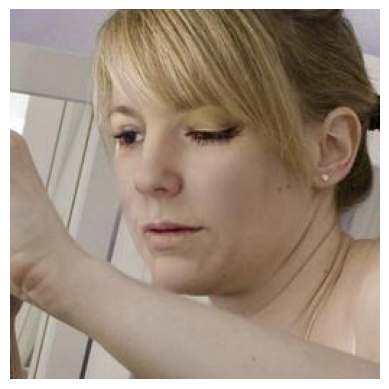

In [ ]:
# Providing path to dataset
base_dir ='/content/Dataset/Train'
image_path='/content/Dataset/Train/Fake/fake_0.jpg'


# Reading the image
img=mpimg.imread(image_path)
print(img.shape)

#display image
plt.imshow(img)
plt.axis('off')
plt.show()

#Image Parameters
img_size=224
batch_size=32 # batch size can  be increased to speed up the training
              # but we must have efficient RAM

In [ ]:
#Image Data generators
data_gen=ImageDataGenerator(
    rescale=1./255,
    validation_split=0.2 # 20% of testing
)

In [ ]:
#Train Generator
train_gen=data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    subset='training',
    class_mode='categorical'
)


#Validation Generator
valid_gen=data_gen.flow_from_directory(
    base_dir,
    target_size=(img_size,img_size),
    batch_size=batch_size,
    subset='validation',
    class_mode='categorical'
)

Found 112002 images belonging to 2 classes.
Found 28000 images belonging to 2 classes.


Model and its Training

In [ ]:
# Model defination
model=models.Sequential()
model.add(layers.Conv2D(32,(3,3),activation='relu',input_shape=(img_size,img_size,3)))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Conv2D(64,(3,3),activation='relu'))
model.add(layers.MaxPooling2D(2,2))
model.add(layers.Flatten())
model.add(layers.Dense(256,activation='relu'))
model.add(layers.Dense(train_gen.num_classes,activation='softmax'))

#model summary
model.summary()

/usr/local/lib/python3.11/dist-packages/keras/src/layers/convolutional/base_conv.py:107: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(activity_regularizer=activity_regularizer, **kwargs)


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ conv2d_6 (Conv2D)                    │ (None, 222, 222, 32)        │             896 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_6 (MaxPooling2D)       │ (None, 111, 111, 32)        │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ conv2d_7 (Conv2D)                    │ (None, 109, 109, 64)        │          18,496 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ max_pooling2d_7 (MaxPooling2D)       │ (None, 54, 54, 64)          │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ flatten_3 (Flatten)                  │ (None, 186624)              │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 256)                 │      47,776,000 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 2)                   │             514 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 47,795,906 (182.33 MB)

 Trainable params: 47,795,906 (182.33 MB)

 Non-trainable params: 0 (0.00 B)

In [ ]:
# Compile the Model
model.compile(optimizer='adam',loss='categorical_crossentropy',metrics=['accuracy'])

In [ ]:
#Training the Model
history=model.fit(
    train_gen,steps_per_epoch=train_gen.samples//batch_size,
    epochs=5,
    validation_data=valid_gen ,
    validation_steps=valid_gen.samples//batch_size
)

Epoch 1/5


/usr/local/lib/python3.11/dist-packages/keras/src/trainers/data_adapters/py_dataset_adapter.py:122: UserWarning: Your `PyDataset` class should call `super().__init__(**kwargs)` in its constructor. `**kwargs` can include `workers`, `use_multiprocessing`, `max_queue_size`. Do not pass these arguments to `fit()`, as they will be ignored.
  self._warn_if_super_not_called()


3500/3500 ━━━━━━━━━━━━━━━━━━━━ 252s 71ms/step - accuracy: 0.7502 - loss: 0.6258 - val_accuracy: 0.8382 - val_loss: 0.3502
Epoch 2/5
   1/3500 ━━━━━━━━━━━━━━━━━━━━ 3:21 58ms/step - accuracy: 0.7500 - loss: 0.3893

/usr/lib/python3.11/contextlib.py:158: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self.gen.throw(typ, value, traceback)


3500/3500 ━━━━━━━━━━━━━━━━━━━━ 3s 774us/step - accuracy: 0.7500 - loss: 0.3893 
Epoch 3/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 246s 70ms/step - accuracy: 0.8785 - loss: 0.2782 - val_accuracy: 0.8912 - val_loss: 0.2519
Epoch 4/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 0s 8us/step - accuracy: 0.8750 - loss: 0.3084   
Epoch 5/5
3500/3500 ━━━━━━━━━━━━━━━━━━━━ 236s 67ms/step - accuracy: 0.9354 - loss: 0.1599 - val_accuracy: 0.9093 - val_loss: 0.2371


In [ ]:
print("Evaluating model........")
val_loss,val_accuracy=model.evaluate(valid_gen,steps=valid_gen.samples//batch_size)
print(f"validation accuracy:{val_accuracy*100:.2f}%")


Evaluating model........
875/875 ━━━━━━━━━━━━━━━━━━━━ 49s 56ms/step - accuracy: 0.9080 - loss: 0.2401
validation accuracy:90.93%


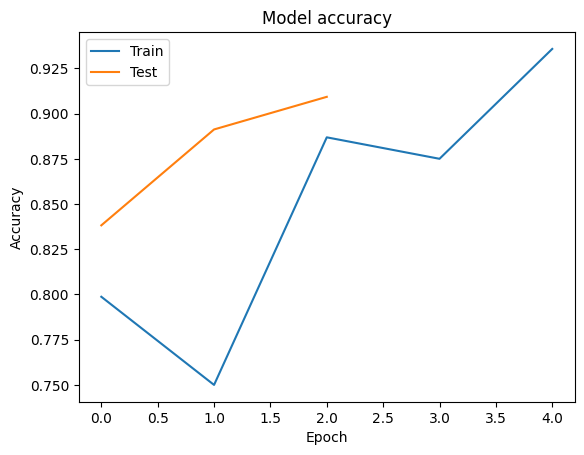

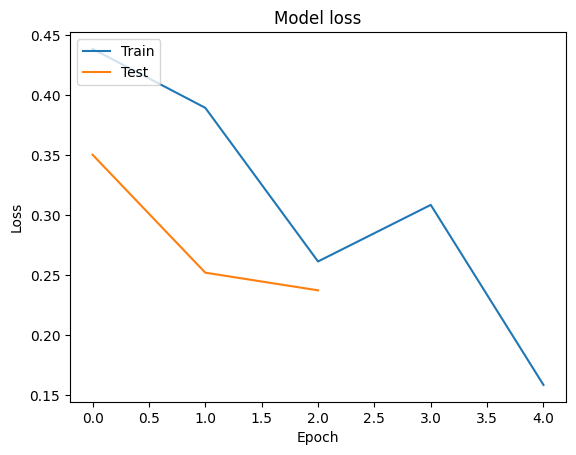

In [ ]:
# Plot training & validation accuracy values
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('Model accuracy')
plt.ylabel('Accuracy')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper left')
plt.show()


# Plot training & validation loss values
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('Model loss')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Train','Test'],loc='upper left')
plt.show()


In [ ]:
# function to load and preprocess the image using pillow
def load_and_preprocess(image_path,target_size=(224,224)):
  img=Image.open(image_path)     #Load the image
  img=img.resize(target_size)    #Resize tthe image
  img_array=np.array(img)        #convert image into numpy array
  img_array=np.expand_dims(img_array,axis=0)  #add batch dimension
  img_array=img_array.astype('float32')/255.  #scale the image value to [0,1]
  return img_array



# function to Predict the class of an Image
def predict_image_class(model,image_path,class_indices):
  preprocessed_img= load_and_preprocess(image_path)
  prediction=model.predict(preprocessed_img)
  predicted_class_index=np.argmax(prediction,axis=1)[0] #it will give you probability value with highest probability
  predicted_class_name = class_indices[predicted_class_index]
  return predicted_class_name

In [ ]:
# create a mapping from class indices to class name
class_indices={v: k for k,v in train_gen.class_indices.items()}
class_indices

{0: 'Fake', 1: 'Real'}

In [ ]:
#Example
image_path='/content/Dataset/Validation/Real/real_10000.jpg'
predicted_class_name = predict_image_class(model, image_path, class_indices)
print("Predicted Class Name:", predicted_class_name)

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 23ms/step
Predicted Class Name: Real


In [ ]:
model.save('model.h5')